This is an example work flow for building a regression model in Python. The dataset that will be used in this example is available for download at https://www.kaggle.com/uciml/autompg-dataset. This dataset contains the techinical specs for a number of cars including the mpg, weight, horsepower and others. For this example I will build a model that predicts the mpg of a car. 

First lets import the required packages and functions for performing the analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

/Users/jonlandrigan/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Now let's import the data and take a look at the head of the dataframe to get a sense of what is in it.

In [2]:
dat = pd.read_csv('auto-mpg.csv')
dat.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


It's also good to take a look at the data types of the dataframe to see what you are working with. 

In [3]:
dat.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight            int64
acceleration    float64
model year        int64
origin            int64
car name         object
dtype: object

As we see in from the data types output although in the head of the dataframe the horsepower column looks like it contains numbers or intergers, in fact it is actually type object which means it contains strings. This is because in this data set missing data is coded as a "?" as shown below.

In [4]:
sum(dat['horsepower'] == "?")

6

Rather then using "?" to code the missing data it is standard practice to code missing data as NA or NaN. We will do this below using replace().

In [5]:
dat.replace(to_replace='?', value = np.nan, inplace=True)
sum(dat['horsepower'].isnull())

6

Now that we have recoded the missing data as null values we can easily drop these from the dataset using dropna(). Note that setting how to "any" means that it will drop any observations in the dataframe that contain na values. 

In [6]:
dat = dat.dropna(how = 'any')
sum(dat['horsepower'].isnull())

0

Now that we have removed the missing values we can change the type of the horsepower column to integer values using astype().

In [7]:
dat['horsepower'] = dat['horsepower'].astype('int64')
dat.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower        int64
weight            int64
acceleration    float64
model year        int64
origin            int64
car name         object
dtype: object

Ok now that we have cleaned up the data a little bit we will take a look at the data visually to get a sense of the relationships between the features.

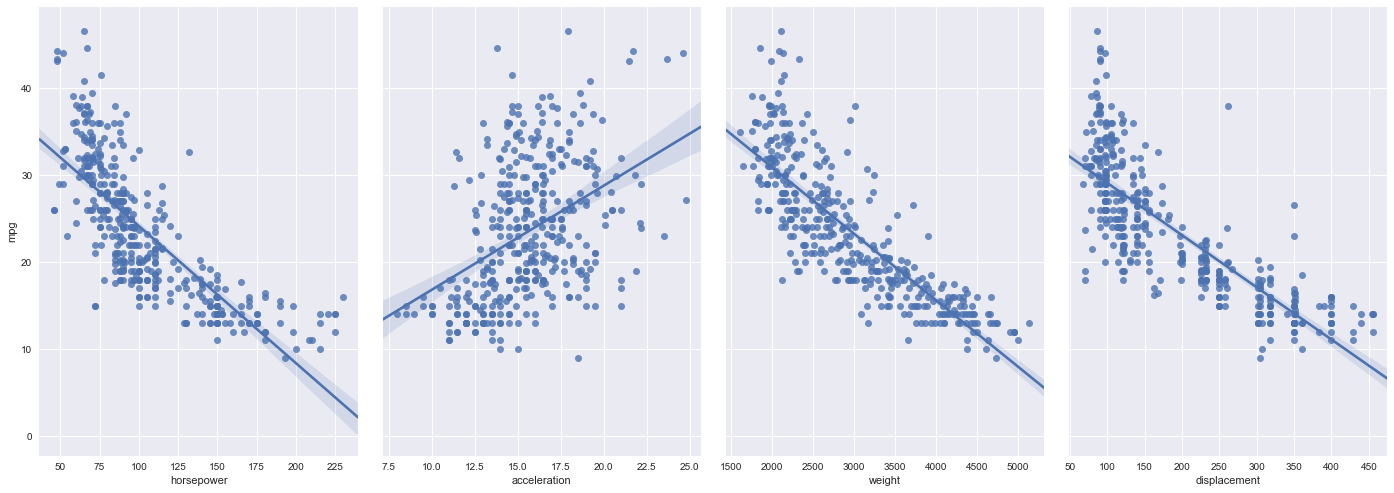

In [8]:
%matplotlib inline
sns.pairplot(dat, x_vars = ['horsepower','acceleration', 'weight', 'displacement'],
             y_vars = 'mpg', size=7, aspect=0.7, kind='reg')

There appear to be some strong relationships present as shown by the plotted regression lines however since the data seems to curve off the lines lets try plotting the data but this time using a higher order fit line.

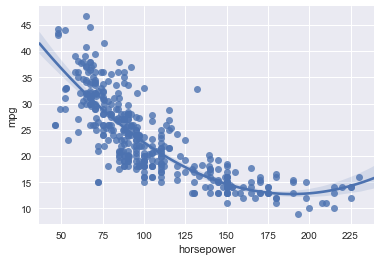

In [9]:
sns.regplot(x='horsepower',y='mpg',data = dat, order = 2)

As can be seen using a polynomial of 2 the fit to the data is much better. Lets do the same for weight and displacement as well.

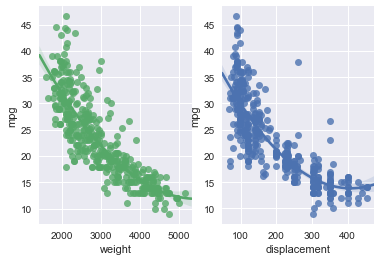

In [10]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols=2,sharex=False, sharey=False)
sns.regplot(x='displacement',y='mpg',data = dat, order = 2, ax=ax2)
sns.regplot(x='weight',y='mpg',data = dat, order = 2, ax=ax1)

Just as with the horsepower using a 2nd order polynomial fit for the displacement and weight appears to be better then a linear line. Therefore when fitting the regression model we will include the 2nd order polynomial transformations of these features using PolynomialFeature transformation and a Pipeline.

In [11]:
#Define the features columns that will be used to fit the model
feature_cols = ['horsepower', 'weight', 'displacement']
#Define the matrix of feature values by subsetting the dat dataframe by the feature columns
X = dat[feature_cols]
#Define the outcome values vector
y = dat['mpg']

#Instantiate the model
model = Pipeline([('poly', PolynomialFeatures(degree=2)), ('linear', LinearRegression(fit_intercept=False))])

#Fit the model and perform 10 fold cross validation
scores = cross_val_score(model, X, y, cv=10, scoring='neg_mean_squared_error')
#Calculate the root mean square erorr
rmse_scores = np.sqrt(-scores)
print(rmse_scores)

[ 2.59591594  4.19184761  4.43025009  3.4090553   3.10637487  1.97793596
  2.82360302  3.98568843  6.73735171  6.29823619]


Now that we have created these feature columns lets train and fit a model to predict the mpg based on these features.

In [12]:
print('The average root mean square error is:',rmse_scores.mean().round(2))
print('The range of mpg values in the data is:',dat['mpg'].max()-dat['mpg'].min())

The average root mean square error is: 3.96
The range of mpg values in the data is: 37.6


The average root mean squared error is 3.96. Given that the range of mpg values in the data set is 37.6 this is pretty good. We could potentially imporve the models performance by adding other features to the model or by using a different model however this risks minimizing the interpretability of the model and therefore it may be less favorable depending on ones needs.